In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # For saving the final model

# Machine Learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             mean_squared_error, r2_score, accuracy_score)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

# Handling Imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # Special pipeline for SMOTE

# Models
from xgboost import XGBClassifier

# Explainability
import shap

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

print("✅ Advanced Libraries Loaded Successfully")

✅ Advanced Libraries Loaded Successfully


In [24]:
# Load the dataset
df = pd.read_excel('loan_dataset.xlsx')

# Convert Date column
df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'])

print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (20000, 33)


,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,BankruptcyHistory,LoanPurpose,PaymentHistory,LengthOfCreditHistory,SavingsAccountBalance,CheckingAccountBalance,TotalAssets,TotalLiabilities,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-06-18,37,36562,553,Employed,High School,14,38934,48,Married,0,Own,782,2.712,4,0,0,Home,26,11,636,1405,2612797,9589,49.207,4,2603208,257.434,22.178,1230.4,6.605,1,42.4
1,2054-02-27,77,84454,676,Unemployed,Bachelor,55,9856,36,Divorced,4,Mortgage,677,20.048,6,0,0,Home,22,25,3828,1027,2619627,20691,9.744,6,2598936,156.856,1.482,3408.1,14.462,1,30.4
2,2059-01-20,36,55540,614,Employed,High School,11,21670,12,Married,1,Mortgage,739,1.714,2,0,0,Home,25,3,9787,799,2141590,33311,8.786,3,2108279,17.967,21.558,2023.5,5.968,1,34.4
3,2042-09-07,28,88051,523,Employed,Associate,7,17982,36,Married,2,Rent,795,4.903,3,0,0,Auto,23,18,2682,13189,2131807,24934,8.834,1,2106873,241.482,27.021,734.3,20.842,1,33.6
4,2032-01-08,23,21775,581,Employed,Bachelor,3,67419,36,Married,1,Mortgage,583,11.189,4,1,0,Home,25,9,1835,408,2123832,34883,674.315,5,2088949,261.919,2.613,2721.1,1.820,0,44.0


In [25]:
# 1. Monthly Income
df['MonthlyIncome'] = df['AnnualIncome'] / 12

# 2. Debt-to-Income Ratio (DTI)
df['Calculated_DTI'] = (df['MonthlyDebtPayments'] + df['MonthlyLoanPayment']) / (df['MonthlyIncome'] + 1)

# 3. Loan-to-Value Ratio (LTV)
df['LTV'] = df['LoanAmount'] / (df['TotalAssets'] + 1)

# 4. Liquidity Ratio (Runway)
df['Liquidity_Ratio'] = (df['SavingsAccountBalance'] + df['CheckingAccountBalance']) / (df['MonthlyLoanPayment'] + 1)

# 5. Disposable Income
df['Disposable_Income'] = df['MonthlyIncome'] - (df['MonthlyDebtPayments'] + df['MonthlyLoanPayment'])

print("✅ Financial Features Engineered")

✅ Financial Features Engineered


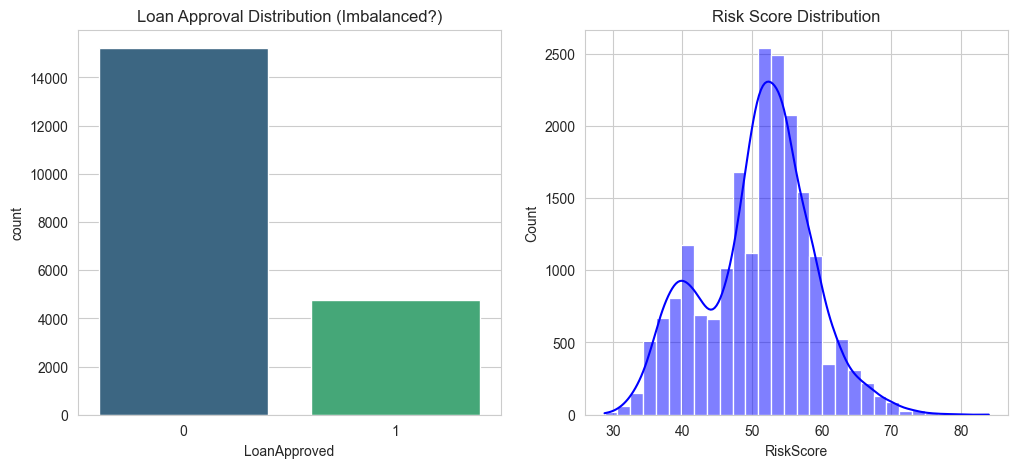

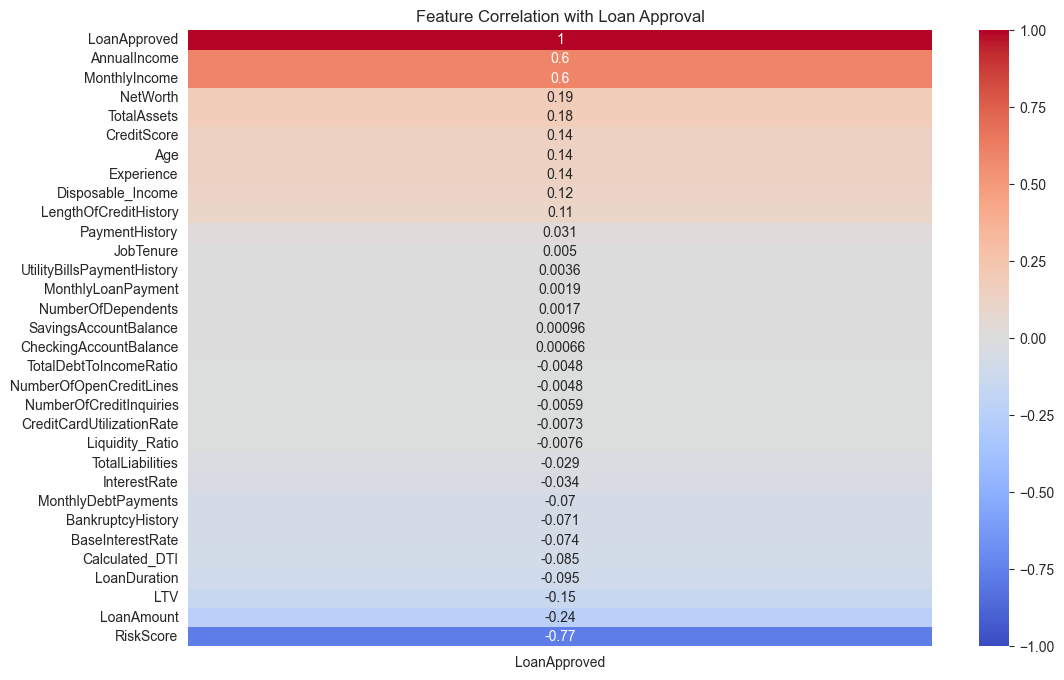

In [26]:
# Visualize the target distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='LoanApproved', data=df, palette='viridis')
plt.title("Loan Approval Distribution (Imbalanced?)")

plt.subplot(1, 2, 2)
sns.histplot(df['RiskScore'], bins=30, kde=True, color='blue')
plt.title("Risk Score Distribution")
plt.show()

# Correlation Matrix (Top Numerical Features)
plt.figure(figsize=(12, 8))
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['float64', 'int64'])
# compute correlation
corr = numeric_df.corr()
# Plot heatmap of correlations with LoanApproved
target_corr = corr[['LoanApproved']].sort_values(by='LoanApproved', ascending=False)
sns.heatmap(target_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation with Loan Approval")
plt.show()

In [27]:
# Separate Features and Targets
X = df.drop(columns=['LoanApproved', 'RiskScore', 'ApplicationDate'])
y_class = df['LoanApproved']
y_reg = df['RiskScore']

# Split Data (Stratified for Classification)
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42, stratify=y_class)

# Identify Column Types
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define Preprocessing Steps
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

print("✅ Preprocessing Pipeline Created")

✅ Preprocessing Pipeline Created


In [28]:
print("--- COMPARING MODELS ---")

# We use ImbPipeline to handle SMOTE correctly inside Cross-Validation
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

results = []

for name, model in models.items():
    # Create a full pipeline with SMOTE
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    # 3-Fold Cross-Validation (Simulates 3 different training runs)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='roc_auc')
    results.append({'Model': name, 'AUC Score': cv_scores.mean()})

results_df = pd.DataFrame(results).sort_values(by='AUC Score', ascending=False)
print(results_df)

best_model_name = results_df.iloc[0]['Model']
print(f"\n🏆 Best Model Selected: {best_model_name}")

--- COMPARING MODELS ---
                 Model  AUC Score
2              XGBoost   0.980549
0  Logistic Regression   0.970040
1        Random Forest   0.960554

🏆 Best Model Selected: XGBoost


--- TUNING HYPERPARAMETERS (XGBoost) ---
Best Parameters: {'classifier__subsample': 0.8, 'classifier__n_estimators': 200, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.2}

Final Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3044
           1       0.89      0.87      0.88       956

    accuracy                           0.94      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.94      0.94      0.94      4000



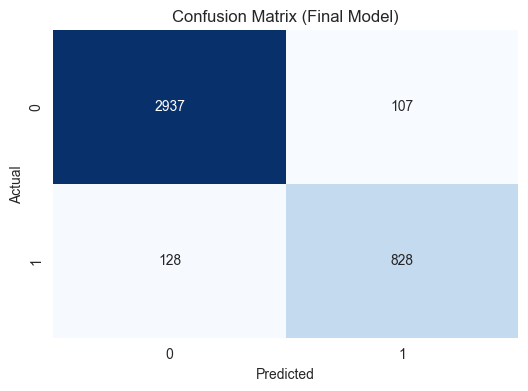

In [29]:
print("--- TUNING HYPERPARAMETERS (XGBoost) ---")

# Define the model pipeline
xgb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(eval_metric='logloss', random_state=42))
])

# Define Search Space
param_dist = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.8, 1.0]
}

# Randomized Search (Faster than GridSearch)
random_search = RandomizedSearchCV(
    xgb_pipeline, 
    param_distributions=param_dist, 
    n_iter=5, # Number of combinations to try
    cv=3, 
    scoring='roc_auc', 
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Get Best Model
best_clf_model = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

# Final Evaluation
y_pred = best_clf_model.predict(X_test)
print("\nFinal Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix (Final Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

--- OBJECTIVE B: RISK SCORE PREDICTION ---
RMSE: 4.46
R² Score: 0.6732


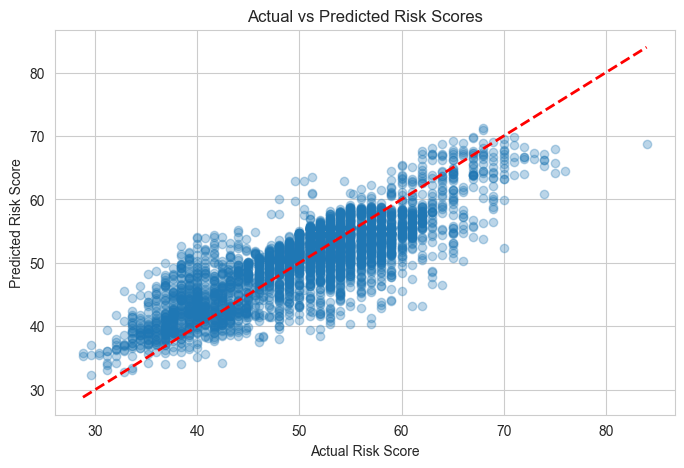

In [30]:
print("--- OBJECTIVE B: RISK SCORE PREDICTION ---")

# Split Data for Regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Pipeline
reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))
])

reg_pipeline.fit(X_train_reg, y_train_reg)

# Predictions
y_pred_reg = reg_pipeline.predict(X_test_reg)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Visual Check
plt.figure(figsize=(8, 5))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.3)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel("Actual Risk Score")
plt.ylabel("Predicted Risk Score")
plt.title("Actual vs Predicted Risk Scores")
plt.show()

--- EXPLAINABILITY ANALYSIS ---


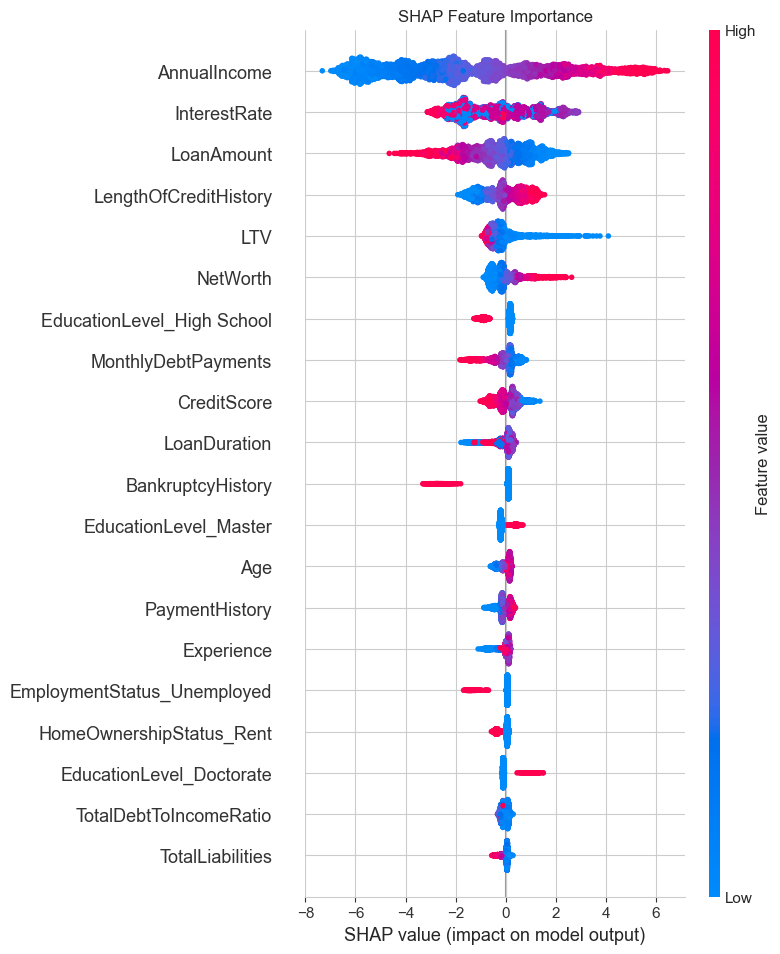

In [31]:
print("--- EXPLAINABILITY ANALYSIS ---")

# We need the transformed data for SHAP
# Extract the model step
xgb_model = best_clf_model.named_steps['classifier']

# Transform X_test using the preprocessor
X_test_transformed = best_clf_model.named_steps['preprocessor'].transform(X_test)

# Get feature names
new_cat_names = best_clf_model.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(new_cat_names)

# SHAP Explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_transformed)

# Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_transformed, feature_names=all_feature_names, show=False)
plt.title("SHAP Feature Importance")
plt.show()

In [32]:
print("--- SAVING MODELS FOR DEPLOYMENT ---")

# Save the Classification Pipeline
joblib.dump(best_clf_model, 'loan_approval_pipeline.pkl')

# Save the Regression Pipeline
joblib.dump(reg_pipeline, 'risk_score_pipeline.pkl')

print("✅ Models saved successfully as .pkl files")
print("   - loan_approval_pipeline.pkl")
print("   - risk_score_pipeline.pkl")

--- SAVING MODELS FOR DEPLOYMENT ---
✅ Models saved successfully as .pkl files
   - loan_approval_pipeline.pkl
   - risk_score_pipeline.pkl


In [33]:
print("--- SAVING MODELS FOR DEPLOYMENT ---")

# Save the Classification Pipeline
joblib.dump(best_clf_model, 'loan_approval_pipeline.pkl')

# Save the Regression Pipeline
joblib.dump(reg_pipeline, 'risk_score_pipeline.pkl')

print("✅ Models saved successfully as .pkl files")
print("   - loan_approval_pipeline.pkl")
print("   - risk_score_pipeline.pkl")

--- SAVING MODELS FOR DEPLOYMENT ---
✅ Models saved successfully as .pkl files
   - loan_approval_pipeline.pkl
   - risk_score_pipeline.pkl
